In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import tree
from sklearn.neural_network import MLPRegressor

In [2]:
df = pd.read_csv('./data/01_removed_outliers/Lake_Bilancino.csv', sep=',', header=0, index_col=0)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

<AxesSubplot:>

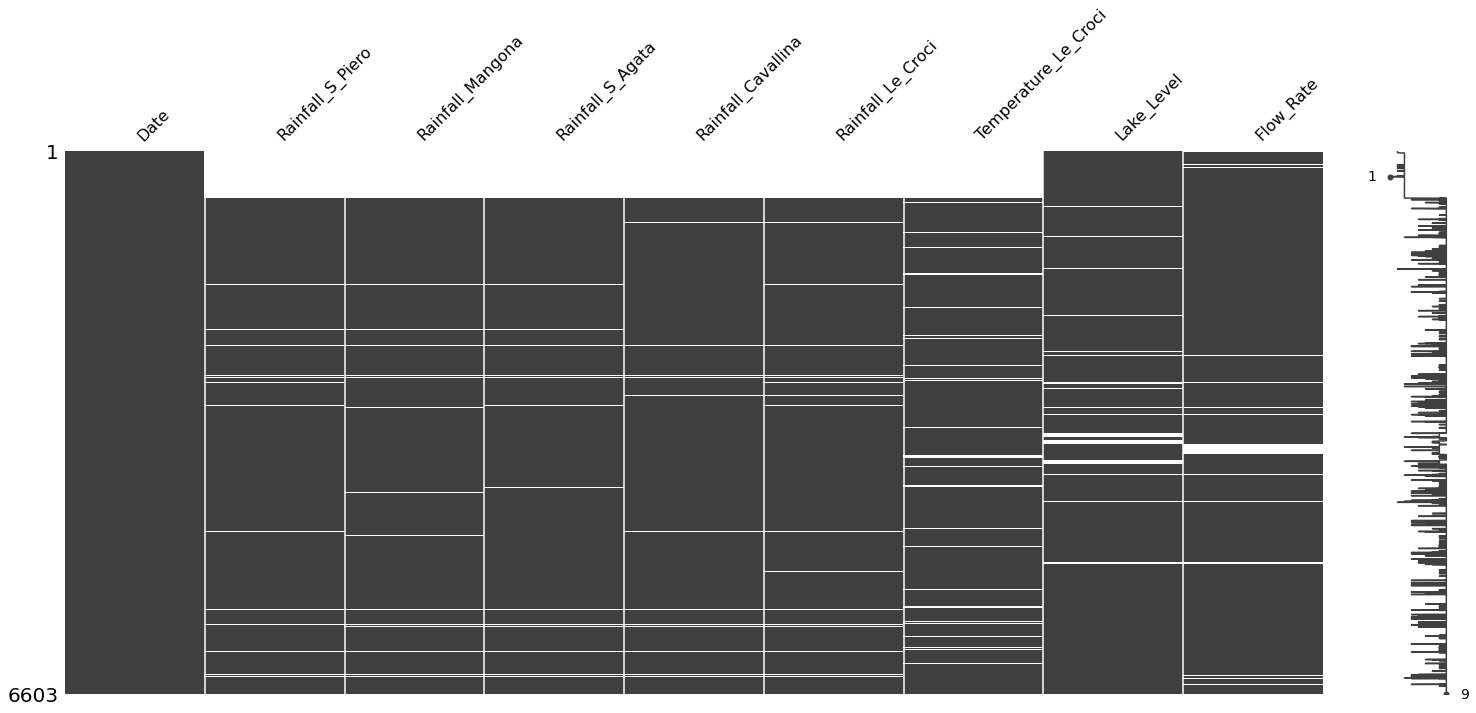

In [3]:
# outliers were removed in previous step
msno.matrix(df)

In [4]:
# we cut out top rows with most missing values
df = df.loc[df['Date'] >= '2004-01-01']

,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
Rainfall_S_Piero,1.000000,0.805152,0.860220,0.869389,0.862395,-0.143844,-0.005017,0.062759
Rainfall_Mangona,0.805152,1.000000,0.814781,0.823178,0.820839,-0.153080,-0.016338,0.077262
Rainfall_S_Agata,0.860220,0.814781,1.000000,0.850801,0.854746,-0.150761,-0.003793,0.084660
Rainfall_Cavallina,0.869389,0.823178,0.850801,1.000000,0.894008,-0.134049,-0.014958,0.068350
Rainfall_Le_Croci,0.862395,0.820839,0.854746,0.894008,1.000000,-0.152530,-0.017926,0.078491
Temperature_Le_Croci,-0.143844,-0.153080,-0.150761,-0.134049,-0.152530,1.000000,0.081849,-0.198726
Lake_Level,-0.005017,-0.016338,-0.003793,-0.014958,-0.017926,0.081849,1.000000,0.262826
Flow_Rate,0.062759,0.077262,0.084660,0.068350,0.078491,-0.198726,0.262826,1.000000


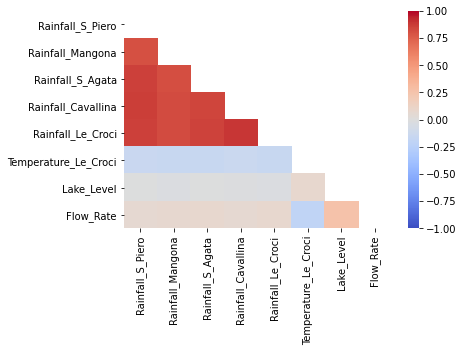

In [5]:
def correlation_matrix(df):
    corr = df.corr(method='pearson')
    sns.heatmap(corr, mask=np.triu(np.ones_like(corr, dtype=bool)), xticklabels=corr.columns, yticklabels=corr.columns, vmin=-1, vmax=1, cmap='coolwarm')
    return corr

correlation_matrix(df)

In [6]:
# Correlated rainfal are redundant we keep just Cavallina rainfall because it is located next the lake.
df = df.drop(['Rainfall_S_Piero', 'Rainfall_Mangona', 'Rainfall_S_Agata', 'Rainfall_Le_Croci'], axis=1, errors='ignore')
df

,Date,Rainfall_Cavallina,Temperature_Le_Croci,Lake_Level,Flow_Rate
577,2004-01-01,0.0,NaN,251.14,0.5
578,2004-01-02,0.0,6.50,251.21,0.5
579,2004-01-03,0.0,4.45,251.28,0.5
580,2004-01-04,0.0,NaN,251.35,0.5
581,2004-01-05,0.0,NaN,251.37,0.5
...,...,...,...,...,...
6598,2020-06-26,0.0,22.50,250.85,0.6
6599,2020-06-27,0.0,23.40,250.84,0.6
6600,2020-06-28,0.0,21.50,250.83,0.6
6601,2020-06-29,0.0,23.20,250.82,0.6


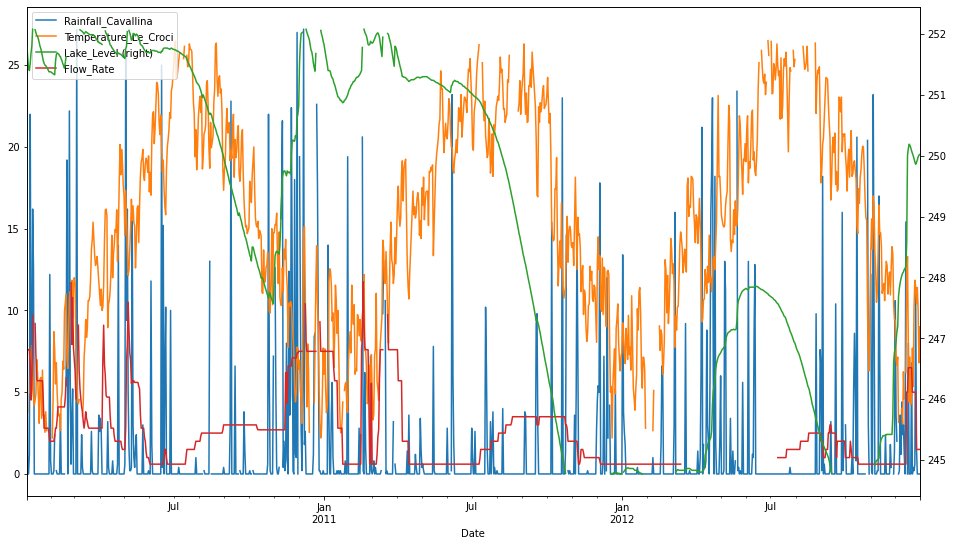

In [7]:
limit=df[(df['Date'] > '2010-01-01') & (df['Date'] < '2013-01-01')]
limit.plot(x='Date', secondary_y=['Lake_Level'], figsize=(16, 9))
plt.show()

,Rainfall_Cavallina,Temperature_Le_Croci,Lake_Level,Flow_Rate,month
Rainfall_Cavallina,1.000000,-0.134049,-0.014958,0.068350,-0.010086
Temperature_Le_Croci,-0.134049,1.000000,0.081849,-0.198726,0.233523
Lake_Level,-0.014958,0.081849,1.000000,0.262826,-0.501790
Flow_Rate,0.068350,-0.198726,0.262826,1.000000,-0.145956
month,-0.010086,0.233523,-0.501790,-0.145956,1.000000


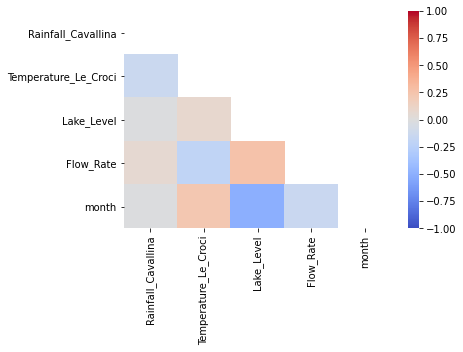

In [8]:
df['month'] = df['Date'].dt.month

# Month has negative correlation with lake level

correlation_matrix(df)

In [10]:
# Spliting data for models

split = df[df['Date'] == '2018-01-01'].index[0]

d = df.dropna()

lrn = d.drop(['Date', 'Lake_Level'], axis=1)
tgt = d['Lake_Level']

lrn_input = lrn[lrn.index < split]
lrn_output = tgt[tgt.index < split]

tgt_input = lrn[lrn.index > split]
tgt_output = tgt[tgt.index > split]


KNR MAE: 0.5633368028948493
KNR RMAE: 0.49667579495991127


<AxesSubplot:xlabel='Date'>

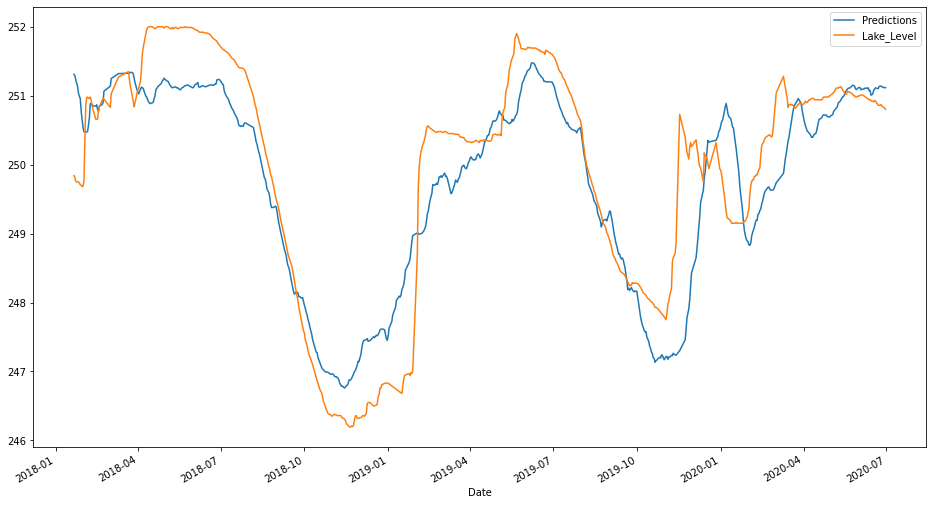

In [13]:
# Observation bigger the K smoother the line
knr = KNeighborsRegressor(n_neighbors=30)

knr.fit(lrn_input, lrn_output)

knr_result = pd.DataFrame({
    'Date': d.loc[d.index > split, 'Date'],
    'Predictions': knr.predict(tgt_input),
    'Lake_Level': tgt_output,
})
knr_result['Predictions'] = knr_result['Predictions'].rolling(20).mean()
knr_result = knr_result.dropna()

print('KNR MAE: {}'.format(mean_absolute_error(knr_result['Predictions'], knr_result['Lake_Level'])))
print('KNR RMAE: {}'.format(mean_squared_error(knr_result['Predictions'], knr_result['Lake_Level'])))

knr_result.plot(x='Date', figsize=(16, 9))